<a href="https://colab.research.google.com/github/lion24/avellaneda-stoikov/blob/master/avellaneda_stoikov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
%pip install -r requirements.txt

In [15]:
import math
import numpy
import matplotlib.pyplot as plt
import brownian as bm
import random
"""
High-frequency trading in a limit order book, Marco Avellaneda & Sasha Stoikov
paper url: https://www.researchgate.net/publication/24086205_High_Frequency_Trading_in_a_Limit_Order_Book

Some model limitations, discussed: https://quant.stackexchange.com/questions/36400/avellaneda-stoikov-market-making-model
Parameter fitting: https://quant.stackexchange.com/questions/36073/how-does-one-calibrate-lambda-in-a-avellaneda-stoikov-market-making-problem
"""

##########################################
#       Simulations
#########################################

n_sim = 1000

pnl_sim = numpy.empty((n_sim))

for i_sim in range(n_sim):

    ##########################################
    #       Stock price
    #########################################

    # The Wiener process parameter.
    sigma = 2
    # Total time.
    T = 1.0
    # Number of steps.
    N = 200 # int(T/dt)
    # Time step size
    dt = T/N # 0.005
    # Create an empty array to store the realizations.
    s = numpy.empty((N+1))
    # Initial value of x.
    s[0] = 100

    bm.brownian(s[0], N, dt, sigma, out=s[1:])

    t = numpy.linspace(0.0, N*dt, N+1)

    # plt.plot(t, s)
    # plt.xlabel('time', fontsize=16)
    # plt.ylabel('price', fontsize=16)
    # plt.grid(True)
    # plt.show()

    ##########################################
    #       Computational loop
    #########################################

    # Limit horizon
    limit_horizon = True

    # Wealth
    pnl = numpy.empty((N+2))
    pnl[0] = 0

    # Cash
    x = numpy.empty((N+2))
    x[0] = 0

    # Inventory
    q = numpy.empty((N+2))
    q[0] = 0
    q_max = 10

    # Risk factor (->0: high risk, ->1: low risk)
    gamma = 0.1

    # Market model
    k = 1.5

    # Reserve price
    r = numpy.empty((N+1))

    # Optimal quotes
    ra = numpy.empty((N+1))
    rb = numpy.empty((N+1))

    # Order consumtion probability factors
    M = s[0]/200
    A = 1./dt/math.exp(k*M/2)

    max_q_held = 0
    min_q_held = 0

    for n in range(N+1):

        # Stock trend
        s[n] = s[n] + 0.1 * n

        # ###############
        # # Option A: Limit time horizon
        if limit_horizon:

            # Reserve price
            r[n] = s[n] - q[n] * gamma * sigma**2*(T-dt*n)

            # Reserve spread
            r_spread = 2 / gamma * math.log(1+gamma/k)

            # optimal quotes
            ra[n] = r[n] + r_spread/2
            rb[n] = r[n] - r_spread/2

        ###############
        # Option B: Unlimit time horizon
        else:

            # Upper bound of inventory position
            w = 0.5 * gamma**2 * sigma**2 * (q_max+1)**2

            # Optimal quotes
            coef = gamma**2*sigma**2/(2*w-gamma**2*q[n]**2*sigma**2)

            ra[n] = s[n] + math.log(1+(1-2*q[n])*coef)/gamma
            rb[n] = s[n] + math.log(1+(-1-2*q[n])*coef)/gamma

            # Reserve price
            r[n] = (ra[n] + rb[n])/2

        # Reserve deltas
        delta_a = ra[n] - s[n]
        delta_b = s[n] - rb[n]

        # Intensities
        lambda_a = A * math.exp(-k*delta_a)
        lambda_b = A * math.exp(-k*delta_b)

        # Order consumption (can be both per time step)
        ya = random.random()
        yb = random.random()

        dNa = 0
        dNb = 0

        prob_ask = 1 - math.exp(-lambda_a*dt) # 1-exp(-lt) or just lt?
        prob_bid = 1 - math.exp(-lambda_b*dt)

        if ya < prob_ask:
            dNa = 1
        if yb < prob_bid:
            dNb = 1

        q[n+1] = q[n] - dNa + dNb
        x[n+1] = x[n] + ra[n]*dNa - rb[n]*dNb
        pnl[n+1] = x[n+1] + q[n+1]*s[n]

        if q[n+1] > max_q_held:
            max_q_held = q[n+1]
        if q[n+1] < min_q_held:
            min_q_held = q[n+1]

    pnl_sim[i_sim] = pnl[-1]

print("Last simulation results:\n")

print("Final inventory hold: ", q[-1])
print("Last price: ", s[-1])
print("Cash: ", x[-1])
print("Final wealth: ", pnl[n+1])
print("Max q held: ", max_q_held)
print("Min q held: ", min_q_held)

Last simulation results:

Final inventory hold:  1.0
Last price:  120.14767547483879
Cash:  -82.20639608757713
Final wealth:  37.94127938726166
Max q held:  2.0
Min q held:  -4.0


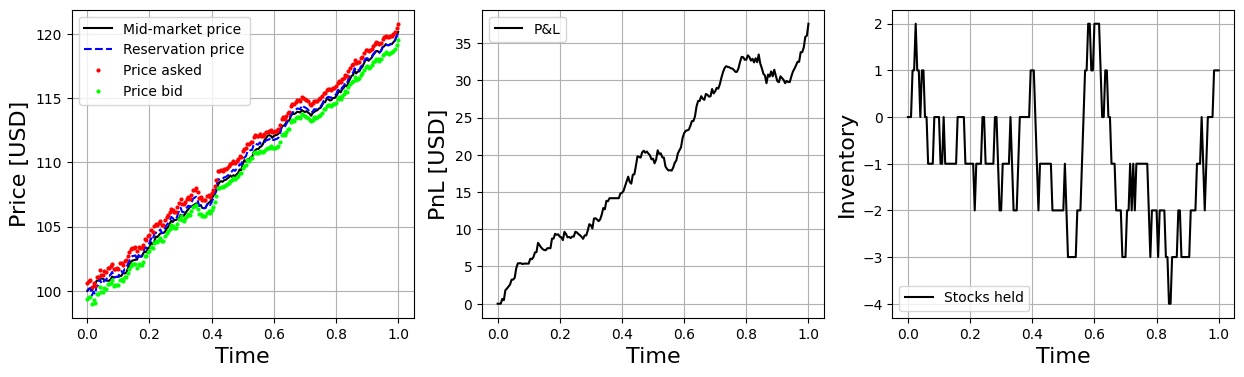

In [16]:
f = plt.figure(figsize=(15, 4))
f.add_subplot(1,3, 1)
plt.plot(t, s, color='black', label='Mid-market price')
plt.plot(t, r, color='blue', linestyle='dashed', label='Reservation price')
plt.plot(t, ra, color='red', linestyle='', marker='.', label='Price asked', markersize='4')
plt.plot(t, rb, color='lime', linestyle='', marker='o', label='Price bid', markersize='2')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Price [USD]', fontsize=16)
plt.grid(True)
plt.legend()

f.add_subplot(1,3, 2)
plt.plot(t, pnl[:-1], color='black', label='P&L')
plt.xlabel('Time', fontsize=16)
plt.ylabel('PnL [USD]', fontsize=16)
plt.grid(True)
plt.legend()

f.add_subplot(1,3, 3)
plt.plot(t, q[:-1], color='black', label='Stocks held')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Inventory', fontsize=16)
plt.grid(True)
plt.legend()

plt.show()


Parameters used in simulations:

gamma: 0.100
k: 1.500
sigma: 2.000
T: 1.00
n steps: 200
Using limited horizon: True

Results over: 1000 simulations

Average PnL: 54.21
Standard deviation PnL: 11.94


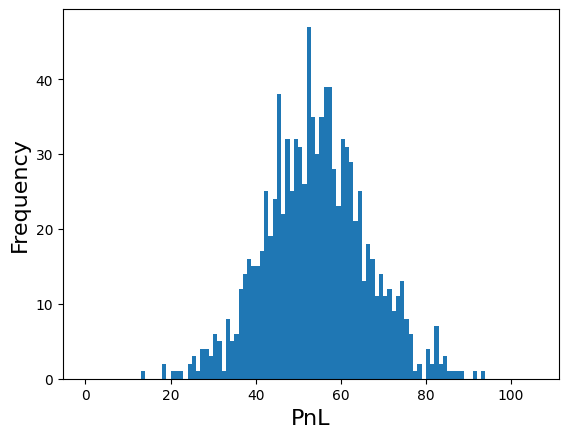

In [17]:
print("\nParameters used in simulations:\n")

print("gamma: %.3f"%gamma)
print("k: %.3f"%k)
print("sigma: %.3f"%sigma)
print("T: %.2f"%T)
print("n steps: %d"%N)
print("Using limited horizon:", limit_horizon)

print("\nResults over: %d simulations\n"%n_sim)

print("Average PnL: %.2f"% numpy.mean(pnl_sim))
print("Standard deviation PnL: %.2f"% numpy.std(pnl_sim))

range_min = int(min(pnl_sim) - abs(min(pnl_sim)))
range_max = int(max(pnl_sim) + abs(min(pnl_sim)))

plt.hist(pnl_sim, bins=range_max-range_min, range=(range_min, range_max))
plt.xlabel('PnL', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()